Todo:
* Chart of account age. Show how many newbies - done
* Chart of account size -done
* Hide compromised accounts - done

In [10]:
# Build a list of active users suitable for a Hive post
# Loads users from file users.txt. Lines starting with R are regions

from datetime import datetime, timedelta, date
from beem import Hive
from beem.account import Account
from beem.amount import Amount
from beem.comment import Comment
from beem.exceptions import ContentDoesNotExistsException
from beem.instance import set_shared_blockchain_instance
import matplotlib.pyplot as plt

In [11]:
hive = Hive()
set_shared_blockchain_instance(hive)
stop = datetime.utcnow() - timedelta(days=31) # Checks last month

In [12]:
hacked = []
with open('steemengineteam_group.txt','r') as f:
    for l in f:
        hacked.append(l.strip())

In [13]:
def useractive(user):
    # Work back looking for last post/comment or vote
    acc = Account(user)#, blockchain_instance=hive)
    voted = commented = False

    for a in acc.history_reverse(stop=stop, only_ops=["vote", 
                                                      "comment"]):
        if a["type"] == "vote":
            voted = True
        if a["author"] == user:
            if a["type"] == "comment":
                commented = True
                break # Don't need to check if they voted as well
            
    return (voted, commented)

In [14]:
def output_region(region, active, voting, inactive):
    if region != None:
        act, voter, inact = len(active), len(voting), len(inactive)
        print(f'## {region} ({act}/{voter}/{inact})')
        if act:
            print('Posting: @'+ (', @'.join(sorted(active))))
            print()
        if voter:
            print('Voting: @'+ (', @'.join(sorted(voting))))
            print()
        if inact:
            print('Inactive: @'+ (', @'.join(sorted(inactive))))
            print()

In [15]:
with open('users.txt', 'r') as f:
    active = []
    inactive = []
    voting =[]
    region = None
    now = datetime.utcnow() 
    total_active = 0
    fish = {'redfish': 0, 'minnow':0, 'dolphin':0, 'orca':0, 'whale':0}
    age = {'month':0, '2month':0, '3month':0, 'year':0, 'older':0}
    for l in f:
        fields = l.split(',')
        if fields[0] == 'R':
            output_region(region, active, voting, inactive)
            total_active += len(active) # Will not count the last region, but exclude expats from total anyway
            region = fields[1].strip()
            active, voting, inactive = [], [], []
        else:
            name = dname = fields[0].strip()
            if '(' in name:
                dname = name
                name = name[:(name.find('(')-1)]
            if not name in hacked:
                voter, commenter = useractive(name)
                if commenter:
                    active.append(dname)
                elif voter:
                    voting.append(dname)
                else: # Inactive
                    inactive.append(dname)
                if commenter or voter:
                    acc = Account(name)
                    hp = acc.balances['available'][2].amount_decimal
                    if hp > 1E9:
                        fish['whale'] += 1
                    elif hp > 1E8:
                        fish['orca'] += 1
                    elif hp > 1E7:
                        fish['dolphin'] += 1
                    elif hp > 1E6:
                        fish['minnow'] += 1
                    else:
                        fish['redfish'] += 1

                    for i in acc.get_account_history(0,1):
                        created = cr = datetime.strptime(i['timestamp'], '%Y-%m-%dT%H:%M:%S')
                    accage = (now - created).days
                    if accage > 365:
                        age['older'] += 1
                    elif accage > 90:
                        age['year'] += 1
                    elif accage > 60:
                        age['3month'] += 1
                    elif accage > 30:
                        age['2month'] += 1
                    else:
                        age['month'] += 1

    output_region(region, active, voting, inactive)
    print('## Totals')
    print(f'**Total active** UK: {total_active}, Expats: {len(active)}')
    
    print('''
# Charts
This shows the numbers in each category of the active and voting accounts. Level is based on 'VESTS'. Minnow equates to about 535HP and each level is 10x the previous.

This shows when people joined Hive. The last few months are shown separately to make any changes obvious.
    
# UK Witnesses
Please support your local witnesses.
@someguy123, @ura-soul, @cadawg, @whiterosecoffee, @c0ff33a, @shmoogleosukami, @chisdealhd''')


## London and the South East (74/33/53)
Posting: @actuarialuk91 (Cambridge), @adetorrent (London), @andy4475 (Woking @andy-jahm), @atomcollector (@risingstargame @juxtamusic), @audiohive-me, @awah, @basilmarples (Norwich), @bellou61 (Brighton), @benthomaswwd (Northampton), @bettymorgan (London), @bleepcoin, @bullion-paradise (London), @cathgothard (London), @cezary-io, @chadayan (London), @chris-uk (Norwich), @cryptogee, @cryptosneeze, @dannyshine, @davehayes2 (Hayling Island), @davidthompson57, @dbofficial125 (Oxford), @devosdevosi (London), @djjamesblack (Brighton), @dolphinartuk (Essex), @donatello, @dubble (London), @edenmichelle, @elmerlin (London), @gillianpearce (Brighton), @greensmile, @imfarhad, @independentpress (London), @jaxsonmurph, @kaywoods, @kgakakillerg (@gmlrecordz @kggymlife), @kph (Ipswich), @lloyddavis (@steemcampuk @lloyd-social), @maneco64, @mightyrocklee (Bedfordshire), @ministickupboy (Brighton), @moemanmoesly, @molometer, @nakedverse, @namiks, @nathanmars, @ni

## Expats (23/4/9)
Posting: @abdex9, @accelerator (@rycharde Thailand), @adambarratt (@abtv Spain), @cristina-zac (Spain), @cryptoandcoffee (South Africa), @eco-alex (Planet Earth), @elricmoonslayer (Spain), @felt.buzz (France), @hirohurl (Japan), @jackglory (USA), @lucylin (Thailand), @mangomayhem (Philippines), @minismallholding (Australia), @nathen007 (@leedsunited Thailand), @revisesociology (Portugal), @ripebanana (Trinidad and Tobago), @samstonehill (France), @sebcam (USA), @shepz1 (Poland), @starkerz (Cyberspace), @stbangkok (Thailand), @trucklife-family (The Earth), @wispsi (Vietnam)

Voting: @eftnow (Spain), @justinchicken (Japan), @mattsbeamer (Russia), @tggr (Singapore)

Inactive: @beckymeep (USA), @biggypauls (Philippines), @dansensei (Japan), @jeffandhisguitar (SE Asia), @l0tti3 (South Africa), @livelovejourney (Majorca), @milliganstravels (Thailand), @moonyoga (Portugal), @thinkit (Thailand)

## Totals
**Total active** UK: 212, Expats: 23

# Charts
This shows the numbers 

{'redfish': 192, 'minnow': 111, 'dolphin': 36, 'orca': 14, 'whale': 0}


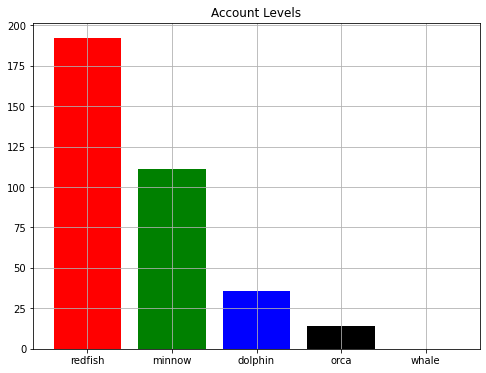

In [18]:
print(fish)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.bar(fish.keys(), fish.values(), color=['red','green','blue','black','gray']);
plt.title('Account Levels')
ax.grid()

{'month': 5, '2month': 6, '3month': 12, 'year': 58, 'older': 272}


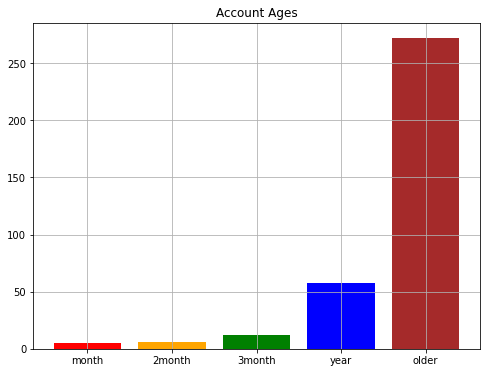

In [19]:
print(age)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.bar(age.keys(), age.values(), color=['red', 'orange', 'green','blue','brown']);
plt.title('Account Ages')
ax.grid()